### Installation

In [1]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
    !pip install --no-deps unsloth

### Unsloth

In [ ]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen2.5-VL-3B-Instruct-bnb-4bit",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

We now add LoRA adapters for parameter efficient finetuning.

In [166]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = False, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

Unsloth: Making `model.base_model.model.model` require gradients


<a name="Data"></a>
### Data Prep
We'll be using Image Captioning Dataset from VizWiz. More about the dataset can be found here: https://vizwiz.org/tasks-and-datasets/image-captioning/

In [4]:
import os
import zipfile
import urllib.request

# Create a directory to store the dataset
os.makedirs("vizwiz_dataset", exist_ok=True)
train_zip_path = "vizwiz_dataset/train.zip"
ann_zip_path = "vizwiz_dataset/train.zip"


# Download the zip file
url_train = "https://vizwiz.cs.colorado.edu/VizWiz_final/images/train.zip"
urllib.request.urlretrieve(url_train, train_zip_path)

url_ann = "https://vizwiz.cs.colorado.edu/VizWiz_final/caption/annotations.zip"
urllib.request.urlretrieve(url_ann, ann_zip_path)

# Unzip it
with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
    zip_ref.extractall("vizwiz_dataset/train_images")

with zipfile.ZipFile(ann_zip_path, 'r') as zip_ref:
    zip_ref.extractall("vizwiz_dataset/annotations")

In [7]:
from datasets import Dataset
import datasets
import json

# Load the train dataset annotations
with open("vizwiz_dataset/annotations/train.json", "r") as f:
    train_caption = json.load(f)

# Prepare data into HF format
data = []
seen = set()  # keeps track of image_ids we’ve already kept

# As there are 5 annotations to each image, this code chooses the first annotation to match each image.
# This is because we are training on each image once.
for ann in train_caption["annotations"]:
    image_id = ann["image_id"]
    if image_id in seen:  # we already stored the first caption for this image
        continue

    seen.add(image_id)    # mark this image as handled
    image_path = f"vizwiz_dataset/train_images/train/VizWiz_train_{image_id:08d}.jpg"
    caption = ann["caption"]
    data.append({"image": image_path, "caption": caption, "image_id": image_id})

# Create dataset
dataset = Dataset.from_list(data)

In [ ]:
dataset

Dataset({
    features: ['image', 'caption', 'image_id'],
    num_rows: 23431
})

To format the dataset, all vision finetuning tasks should be formatted as follows:

```python
[
{ "role": "user",
  "content": [{"type": "text",  "text": Q}, {"type": "image", "image": image} ]
},
{ "role": "assistant",
  "content": [{"type": "text",  "text": A} ]
},
]
```

In [8]:
instruction = "Describe this image."

def convert_to_conversation(sample):
    conversation = [
        { "role": "user",
          "content" : [
            {"type" : "text",  "text"  : instruction},
            {"type" : "image", "image" : sample["image"]} ]
        },
        { "role" : "assistant",
          "content" : [
            {"type" : "text",  "text"  : sample["caption"]} ]
        },
    ]
    return { "messages" : conversation }
pass

Let's convert the dataset into the "correct" format for finetuning:

In [9]:
converted_dataset = [convert_to_conversation(sample) for sample in dataset]

Let's see one of the image.

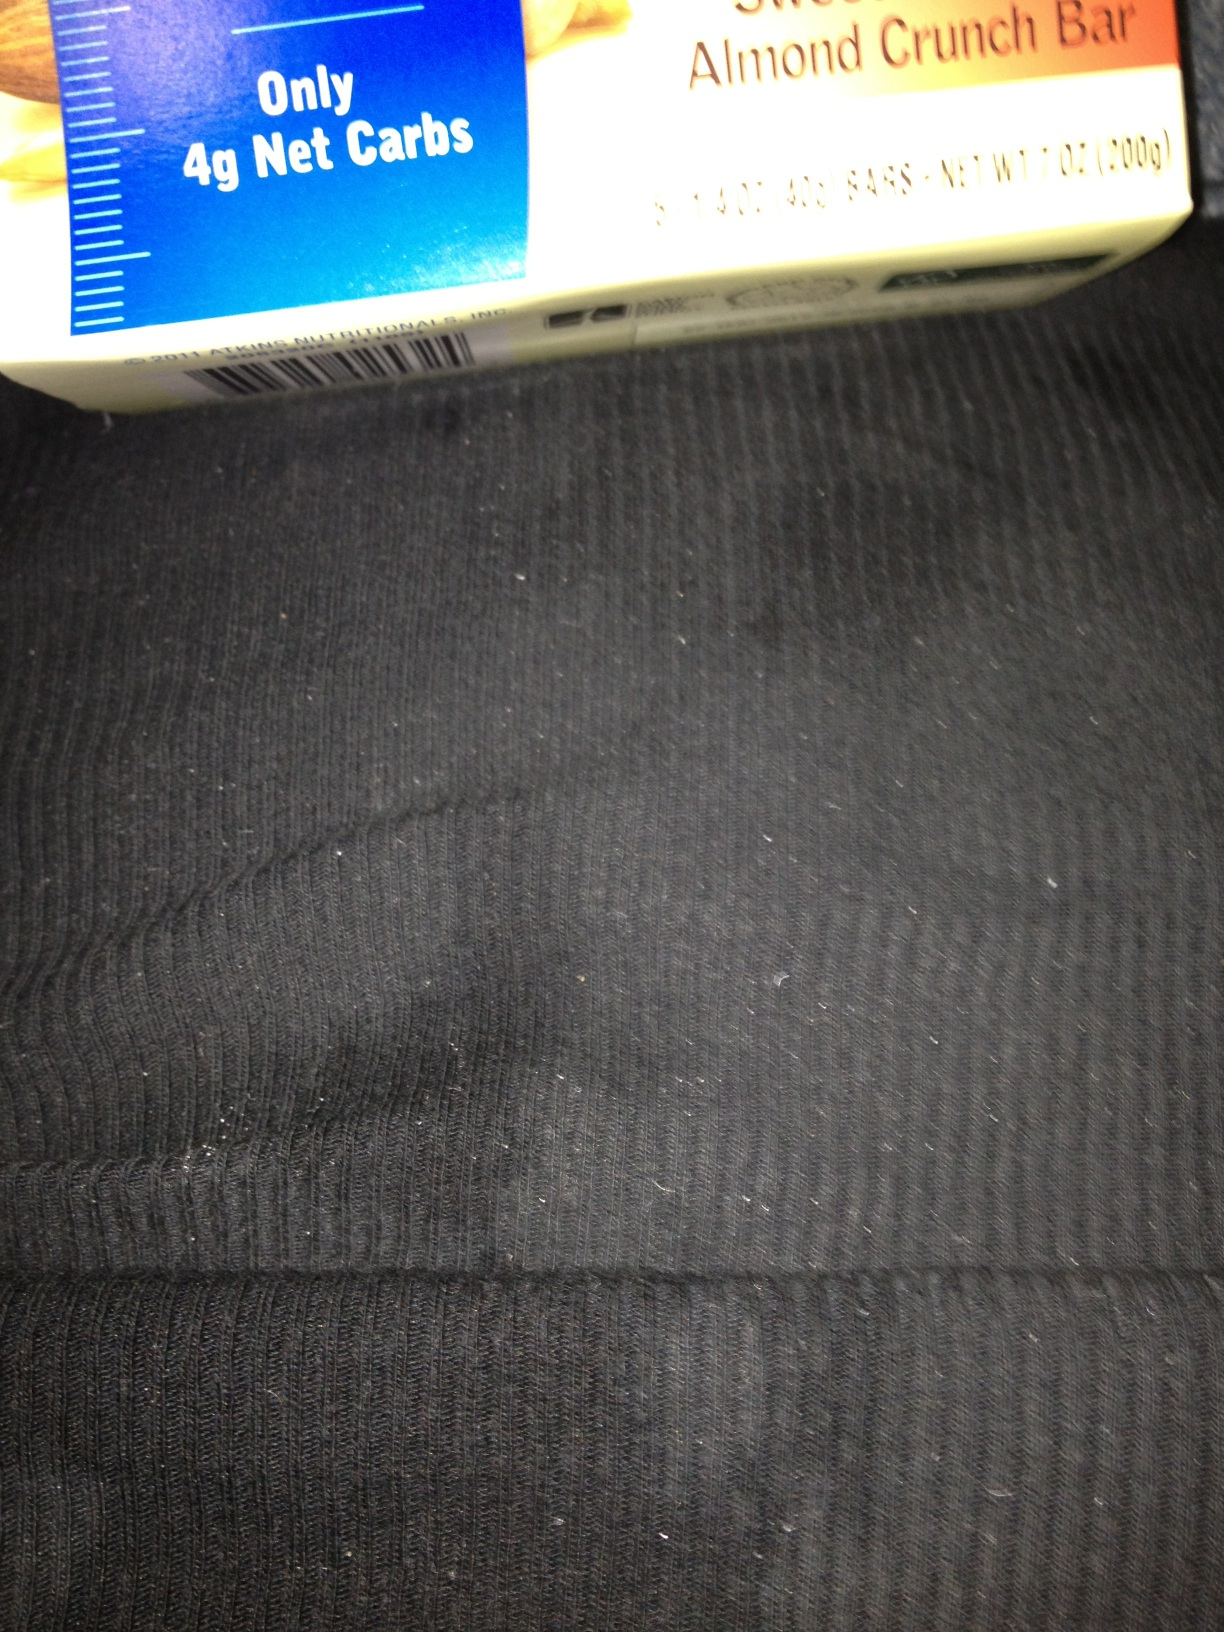

In [ ]:
image = PIL.Image.open(dataset[5001]["image"])
image

Running the pre-trained model without fine-tuning on the image.

In [ ]:
FastVisionModel.for_inference(model) # Enable for inference!
import PIL

image = PIL.Image.open(dataset[5001]["image"])
instruction = "Describe this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

The image shows a close-up of a snack bar package. The visible text on the package indicates that it is an "Almond Crunch Bar" with only 4g of net carbs per serving. The packaging also mentions that there are 5 servings in total, and the net weight is 7 oz (200g). The background appears to be a textured surface, possibly a fabric or carpet.<|im_end|>


<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

We use our new `UnslothVisionDataCollator` which will help in our vision finetuning setup.

In [ ]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig
from transformers import EarlyStoppingCallback
from sklearn.model_selection import train_test_split
from transformers import logging

FastVisionModel.for_training(model) # Enable for training!

# ① ── train / validation split
train_data, val_data = train_test_split(
    converted_dataset, test_size=0.1, random_state=42
)

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = train_data,
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 200,

        # num_train_epochs = 1, # Set this instead of max_steps for full training runs

        # # ── logging / eval / save ──────────────────────────────
        # eval_strategy = "steps",   # or "epoch"
        # eval_steps          = 20,
        # save_strategy       = "steps",
        # save_steps          = 20,
        # load_best_model_at_end = True,
        # metric_for_best_model  = "eval_loss",  # watch eval_loss
        # greater_is_better      = False,        # lower is better
        # ────────────────────────────────────────────────|───────

        learning_rate = 2e-4,
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",     # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 4,
        max_seq_length = 2048,
    ),
)

In [168]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 21,087 | Num Epochs = 1 | Total steps = 200
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 29,933,568/3,000,000,000 (1.00% trained)


Saving model checkpoint to outputs/checkpoint-200
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--unsloth--qwen2.5-vl-3b-instruct-bnb-4bit/snapshots/aa871def981f1770d154df9a5bb1dee2b6303df0/config.json
Model config Qwen2_5_VLConfig {
  "architectures": [
    "Qwen2_5_VLForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "image_token_id": 151655,
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "max_position_embeddings": 32768,
  "max_window_layers": 70,
  "model_type": "qwen2_5_vl",
  "num_attention_heads": 16,
  "num_hidden_layers": 36,
  "num_key_value_heads": 2,
  "pad_token_id": 151654,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "bfloat16",
    "bnb_4bit_quant_storage": "uint8",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": true,
    "llm_int8_enable_fp32_cpu_

In [ ]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

492.7704 seconds used for training.
8.21 minutes used for training.
Peak reserved memory = 3.924 GB.
Peak reserved memory for training = 0.0 GB.
Peak reserved memory % of max memory = 9.92 %.
Peak reserved memory for training % of max memory = 0.0 %.


<a name="Inference"></a>
### Inference


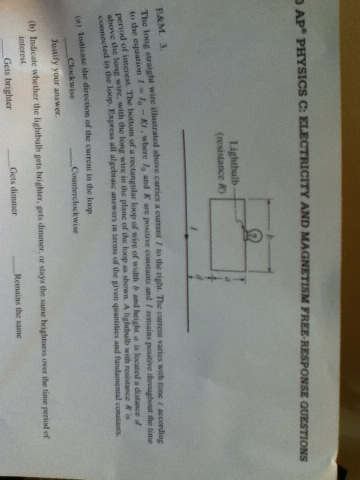

In [149]:
import PIL

image = PIL.Image.open(dataset[5000]["image"])

image

In [150]:
FastVisionModel.for_inference(model) # Enable for inference!

instruction = "Describe this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
out = model.generate(**inputs, max_new_tokens = 30,
                   use_cache = True, temperature = 1.5, min_p = 0.1) #streamer = text_streamer


tensor([[151644,   8948,    198,   2610,    525,    264,  10950,  17847,     13,
         151645,    198, 151644,    872,    198, 151652, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151

# Evaluation

In [13]:
!git clone https://github.com/Yinan-Zhao/vizwiz-caption.git

Cloning into 'vizwiz-caption'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 61 (delta 2), reused 5 (delta 2), pack-reused 51 (from 1)
Receiving objects: 100% (61/61), 93.65 MiB | 60.58 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [14]:
import sys
sys.path.append('/content/vizwiz-caption')
sys.path.append('/content/vizwiz-caption/vizwiz_api')
sys.path.append('/content/vizwiz-caption/vizwiz_eval_cap')  # if `vizwiz_eval_cap` is directly under /content

In [15]:
%matplotlib inline
from vizwiz import VizWiz
from eval import VizWizEvalCap
import matplotlib.pyplot as plt
import skimage.io as io
import numpy as np
import pylab
#pylab.rcParams['figure.figsize'] = (8.0, 10.0)

import json
from json import encoder
encoder.FLOAT_REPR = lambda o: format(o, '.3f')

In [ ]:
# Download Stanford models
!chmod +x /content/vizwiz-caption/get_stanford_models.sh
!/content/vizwiz-caption/get_stanford_models.sh   # for Linux / MacOS

In [ ]:
# Load the caption annotations
with open("vizwiz_dataset/annotations/val.json", "r") as f:
    val_caption = json.load(f)

In [110]:
from datasets import Dataset
import torch
import datasets
import json

# Prepare data into HF format
val_data = []

# as only a small amount of training dataset is used for fine-tuning,
# we use the unseen samples from train dataset for evaluation
# to use validation dataset, download from "https://vizwiz.cs.colorado.edu/VizWiz_final/images/val.zip"
for ann in train_caption["images"][5000:5050]:
    image_id = ann["id"]
    image_path = f"vizwiz_dataset/train_images/train/VizWiz_train_{image_id:08d}.jpg"
    val_data.append({"image": image_path, "image_id": image_id})

# Create dataset
val_dataset = Dataset.from_list(val_data)

In [111]:
val_dataset

Dataset({
    features: ['image', 'image_id'],
    num_rows: 50
})

In [169]:
from tqdm import tqdm
import torch, PIL, json

FastVisionModel.for_inference(model) # Enable for inference!

# IMPORTANT: BATCH_SIZE > 1 is a known bug. It causes the model to infer wrongly. I am still looking for fixes.
BATCH_SIZE     = 1
MAX_NEW_TOKENS = 30
INSTRUCTION    = "Describe this image."

results = []

def flush_batch(batch_imgs, batch_prompts, batch_ids):
    """Tokenize, run generate, decode, append to `results`."""
    if not batch_imgs:
        return

    inputs = tokenizer(
        batch_imgs,
        batch_prompts,
        add_special_tokens=False,
        padding=True,
        return_tensors="pt",
    )

    if (inputs["input_ids"].max() >= model.config.vocab_size) or (inputs["input_ids"].min() < 0):
        raise ValueError("Out‑of‑range token ID detected in batch!")

    inputs = inputs.to("cuda")

    # 3️⃣ Generate captions for whole batch
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=MAX_NEW_TOKENS,
            use_cache=True,
            temperature=1.5,
            min_p=0.1,
        )

    # 4️⃣ Decode and save
    for out, img_id in zip(outputs, batch_ids):
        full_caption = tokenizer.decode(out, skip_special_tokens=True).strip()
        # split once on "assistant\n"
        parts = full_caption.split("assistant\n", 1)
        caption = parts[1].strip() if len(parts) > 1 else full_caption.strip()
        results.append({"image_id": img_id, "caption": caption})

batch_imgs, batch_prompts, batch_ids = [], [], []

for sample in tqdm(val_dataset, desc="Batched inference"):
    try:
        img_id = sample["image_id"]
        img    = PIL.Image.open(sample["image"])

        # build prompt once per sample
        messages = [{"role": "user", "content": [
                        {"type": "image"},
                        {"type": "text", "text": INSTRUCTION},
                    ]}]
        prompt   = tokenizer.apply_chat_template(messages, add_generation_prompt=True)

        batch_imgs.append(img)
        batch_prompts.append(prompt)
        batch_ids.append(img_id)

        # When batch is full, run it
        if len(batch_imgs) == BATCH_SIZE:
            flush_batch(batch_imgs, batch_prompts, batch_ids)
            batch_imgs, batch_prompts, batch_ids = [], [], []

    except Exception as e:
        print(f"⚠️  Skipping image_id={sample['image_id']} due to error:\n{e}")
        continue

# Flush any leftovers in the final (smaller) batch
flush_batch(batch_imgs, batch_prompts, batch_ids)

print(f"Finished! Generated {len(results)} captions.")

Batched inference: 100%|██████████| 50/50 [02:14<00:00,  2.70s/it]

Finished! Generated 50 captions.


In [170]:
output_file = "batch_inference_results.json"
with open(output_file, 'w') as f:
    json.dump(results, f, indent=4)

In [ ]:
results[:5]

In [171]:
with open("batch_inference_results.json", 'r') as f:
  result_file = json.load(f)

In [173]:
eval_caption = {}
eval_caption["info"] = train_caption["info"]
eval_caption["images"] = train_caption["images"][5000:5050]
last_id = eval_caption["images"][-1]["id"]
first_id = eval_caption["images"][0]["id"]
eval_caption["annotations"] = []

count = 0
for ann in train_caption["annotations"]:
  if ann["image_id"] >= first_id and ann["image_id"] <= last_id:
    eval_caption["annotations"].append(ann)

with open('eval.json', 'w') as f:
  json.dump(eval_caption, f)

In [175]:
# file containing groundtruth
annFile = './eval.json'
resFile = './batch_inference_results.json'

In [176]:
vizwiz = VizWiz(annFile, ignore_rejected=True, ignore_precanned=True)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created! imgs = 50, anns = 214


In [177]:
vizwizRes = vizwiz.loadRes(resFile)

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created! imgs = 50, anns = 50


In [178]:
vizwizEval = VizWizEvalCap(vizwiz, vizwizRes)

In [179]:
vizwizEval.evaluate()

tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 519, 'reflen': 495, 'guess': [519, 471, 423, 375], 'correct': [294, 152, 80, 41]}
ratio: 1.0484848484827303
Bleu_1: 0.566
Bleu_2: 0.428
Bleu_3: 0.326
Bleu_4: 0.248
computing Rouge score...
ROUGE_L: 0.400
computing CIDEr score...
CIDEr: 0.895
computing SPICE score...
SPICE: 0.130
computing METEOR score...
METEOR: 0.190


In [180]:
# print output evaluation scores
for metric, score in vizwizEval.eval.items():
    print('%s: %.3f'%(metric, score))

Bleu_1: 0.566
Bleu_2: 0.428
Bleu_3: 0.326
Bleu_4: 0.248
ROUGE_L: 0.400
CIDEr: 0.895
SPICE: 0.130
METEOR: 0.190


<a name="Save"></a>
### Saving, loading finetuned models

In [ ]:
model.push_to_hub("trunghjieu/Qwen-2.5VL-3B-VizWiz", token = "...") # Online saving
tokenizer.push_to_hub("trunghjieu/Qwen-2.5VL-3B-VizWiz", token = "...") # Online saving